# Classification


Original GPflow by *Alexander G. de G. Matthews and James Hensman 2016*

*Adapted to PyTorch by Thomas Viehmann*

This script is similar to

Hensman, Matthews, Ghahramani, AISTATS 2015, Scalable Variational Gaussian Process Classification, Figure 1 Row 1.

It serves to demonstrate sparse variational GP classification on a simple, easily visualized dataset.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import pandas

import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

pyplot.style.use('ggplot')
import IPython

import torch
from torch.autograd import Variable

import candlegp

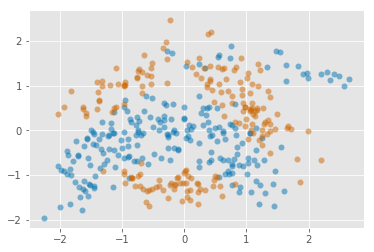

In [2]:
Xtrain = torch.from_numpy(numpy.loadtxt('data/banana_X_train', delimiter=',')).double()
Ytrain = torch.from_numpy(numpy.loadtxt('data/banana_Y_train', delimiter=',').reshape(-1,1)).double()

pyplot.plot(Xtrain[:,0][Ytrain==1].numpy(),Xtrain[:,1][Ytrain==1].numpy(),'o', color='#0172B2', mew=0, alpha=0.5)
pyplot.plot(Xtrain[:,0][Ytrain==0].numpy(),Xtrain[:,1][Ytrain==0].numpy(),'o', color='#CC6600', mew=0, alpha=0.5)

In [3]:
def gridParams():
    mins = [-3.25,-2.85 ] 
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = numpy.linspace( mins[0], maxs[0], nGrid )
    yspaced = numpy.linspace( mins[1], maxs[1], nGrid )
    xx, yy = numpy.meshgrid( xspaced, yspaced )
    Xplot = numpy.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot
     
def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Variable(torch.from_numpy(Xplot)))[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1].numpy(), Xtrain[:,1][Ytrain[:,0]==1].numpy(), 'o', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0].numpy(), Xtrain[:,1][Ytrain[:,0]==0].numpy(), 'o', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'Z'):
        ax.plot(m.Z.get().data.numpy()[:,0], m.Z.get().data.numpy(), 'ko', mew=0, ms=4)
        ax.set_title('{} inducing'.format(m.Z.size(0)))
    ax.contour(xx, yy, p.data.numpy().reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)


0 : 397.6309474339818
20 : 269.44004245263926
40 : 269.3890418215905
60 : 269.38903044385063
80 : 269.38903042737905
0 : 269.3890304139062
20 : 220.16794840177815
40 : 219.7247795246697
60 : 219.7247367886804
80 : 219.7247367717333
0 : 397.6309474339818
20 : 145.12113816339527
40 : 145.05357529081255
60 : 145.05356319378865
80 : 145.05356317732642
0 : 145.05356316390166
20 : 139.72148793498317
40 : 139.71901235771898
60 : 139.71901203824328
80 : 139.71901202302413
0 : 397.6309474339818
20 : 123.2691391300846
40 : 123.07773040810875
60 : 123.07767652144982
80 : 123.0776765044669
0 : 123.07767649059907
20 : 116.38203335636678
40 : 113.83135924079033
60 : 112.89271040432254
80 : 112.88637337047969
0 : 397.6309474339818
20 : 109.58802922316089
40 : 108.89357472528596
60 : 108.89301274447445
80 : 108.89301272654946
0 : 108.89301271183948
20 : 106.98969432983364
40 : 106.89588449587174
60 : 106.86892683681566
80 : 106.86391969364911
0 : 397.6309474339818
20 : 107.30301465775143
40 : 106.7770

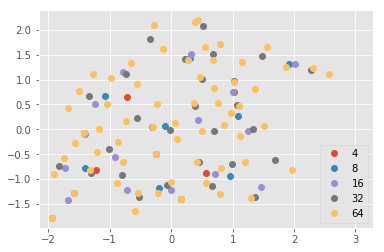

In [7]:
# Setup the experiment and plotting.
Ms = [4, 8, 16, 32, 64]

def optimize(m, lr=5e-3, it=100):
    opt = torch.optim.LBFGS([p for p in m.parameters() if p.requires_grad], lr=lr, max_iter=40)
    def eval_model():
        obj = m()
        opt.zero_grad()
        obj.backward()
        return obj

    for i in range(it):
        obj = m()
        opt.zero_grad()
        obj.backward()
        opt.step(eval_model)
        if i%20==0:
            print(i,':',obj.data[0])
    return -obj.data[0]

# Run sparse classification with increasing number of inducing points
models = []
for index, num_inducing in enumerate(Ms):
    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans
    Z = torch.from_numpy(kmeans(Xtrain.numpy(), num_inducing)[0])
    pyplot.plot(Z[:,0].numpy(),Z[:,1].numpy(),'o', label=num_inducing)
    
    m = candlegp.models.SVGP(Variable(Xtrain), Variable(Ytrain),
                         kern=candlegp.kernels.RBF(2).double(),
                         likelihood=candlegp.likelihoods.Bernoulli(), Z=Variable(Z))
    #Initially fix the hyperparameters.
    m.Z.requires_grad = False
    optimize(m)
    m.Z.requires_grad = True
    optimize(m)
    models.append(m)
    if 0:
        m = gpflow.models.SVGP(Xtrain, Ytrain,
                             kern=gpflow.kernels.RBF(2),
                             likelihood=gpflow.likelihoods.Bernoulli(), Z=Z)
        #Initially fix the hyperparameters.
        m.Z.set_trainable(False)
        m.compile()
        gpflow.train.ScipyOptimizer(options=dict(maxiter=20)).minimize(m)

        #Unfix the hyperparameters.
        m.Z.set_trainable(True)
        gpflow.train.ScipyOptimizer(options=dict(maxiter=200)).minimize(m)
        models.append(m)

xl = pyplot.xlim() ; pyplot.xlim(xl[0], xl[1]+0.5)
pyplot.legend(loc='lower right')

In [5]:
#Run variational approximation without sparsity..
#..be aware that this is much slower.
if 0:
    m = gpflow.models.VGP(Xtrain, Ytrain,
                       kern=gpflow.kernels.RBF(2),
                       likelihood=gpflow.likelihoods.Bernoulli())
    m.compile()
    gpflow.train.ScipyOptimizer(options=dict(maxiter=2000)).minimize(m)
    models.append(m)


[]

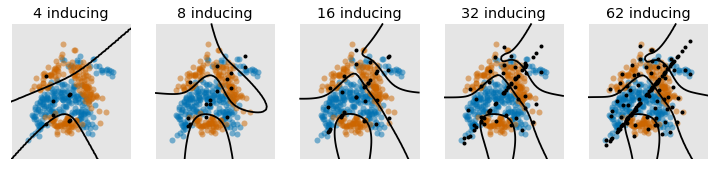

In [13]:
# make plots.
fig, axes = pyplot.subplots(1, len(models), figsize=(12.5, 2.5), sharex=True, sharey=True)
for i, m in enumerate(models):
    plot(m, axes[i])
axes[i].set_yticks([])
axes[i].set_xticks([])

Note that the original implementation and the article do not show the diagonal line of inducing points visible for 32 and 62 inducing. This probably is a bug in the candlegp library.